<a href="https://colab.research.google.com/github/sansadmane/Gravitational-Lensing/blob/main/Copy_of_p2_gravitational_lensing_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PROBLEM 2: Strong gravitational lensing parameter inference

## Problem description
This project’s goal is to infer the mass and lens parameters of a sample of lensing galaxies by their gravitational distortion effect on the image of a background source.

## What’s the main issue?
With upcoming large sky surveys, hundreds of thousands of strong galaxy-galaxy gravitational lenses will be discovered. This is a challenge for characterization of individual lens systems, which can traditionally take multiple days of analysis by experts and traditional inference methods like MCMC.

## Potential solution to this problem?
Convolutional neural networks have shown their capacity for precise and fast (~10,000,000x faster) estimation of strong lensing parameters, which makes the analysis of such a large sample of lenses feasible.

## Milestones
- Craft a neural network for this problem, and its training loop.
- Evaluate the quality of you network, compare it to the litterature on this subject.
- Estimate the network uncertainties on a few parameters of interests. There are multiple approach to this, for example Bayesian Neural Networks, or Simulation-Based Inference methods.
- Compare your posterior with the results of an MCMC, and calibrate your posteriors with a coverage plot. Is you network accurate? Is it precise?


## Useful references
https://arxiv.org/abs/1708.08842 : Fast Automated Analysis of Strong Gravitational Lenses with Convolutional Neural Networks by Hezaveh et al. (2017)
The study of galaxy formation and evolution is an hot topic in current research.

https://arxiv.org/abs/1708.08843 : Uncertainties in Parameters Estimated with Neural Networks: Application to Strong Gravitational Lensing

https://arxiv.org/abs/2012.00042 : Large-Scale Gravitational Lens Modeling with Bayesian Neural Networks for Accurate and Precise Inference of the Hubble Constant by Park et al. (2021)

https://arxiv.org/abs/2112.05278 : Simulation-Based Inference of Strong Gravitational Lensing Parameters by Legin et al (2021)

In [ ]:
!pip install caustic pyro-ppl --quiet

# hihihihihihihihihi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.8/732.8 kB 10.5 MB/s eta 0:00:00


In [ ]:
# Mount Google drive
from google.colab import drive
drive.mount('/content/drive')
path = "drive/MyDrive/"

import torch
from torch.func import vmap
import pyro
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from math import pi
import sys
sys.path.append(path)
from p2_simulator import Simulator, prior

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

Mounted at /content/drive


# Simulator

We need an accurate simulator for a gravitational lensing inference. We will be using our own in-house simulator to simulate gravitational lenses
with simple parametric models.

To make things simple, a simulator is a function $f(\mathbf{x})$ of the parameters of interests, $\mathbf{x}$, which has an output that we can compare directly to our observations, in this case images of gravitational lenses.

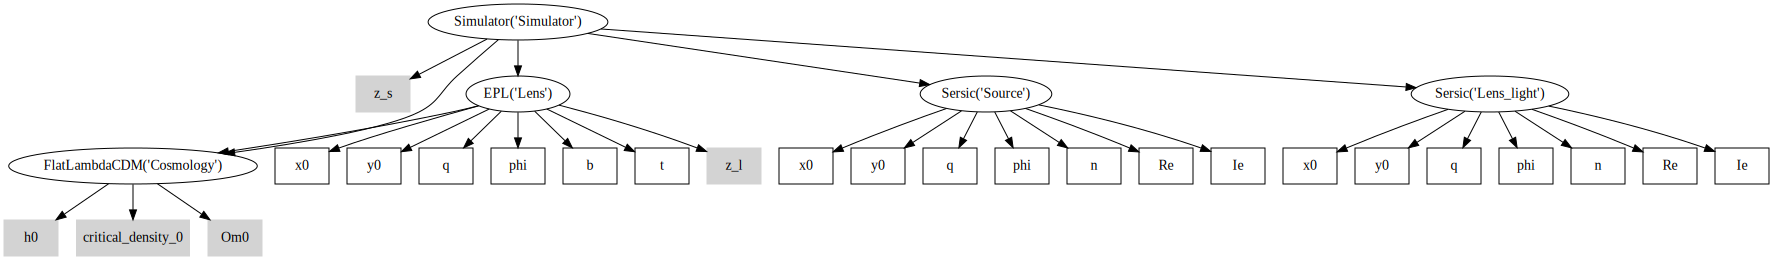

In [ ]:
simulator = Simulator()
simulator.get_graph(show_dynamic_params=True, show_static_params=True)

# Graphical model

We also need a graphical model to sample parameters and observation based on our prior distribution $p(\mathbf{x})$. For this, we will be using the package pyro.

The following does not need to be understood in detail, only that the graphical model will produce instances of every random variables we care about. Those are, of course,
simulated observations $\mathbf{y}$ and parameters of interest $\mathbf{x}$.

We impose the following prior on our parameters, where I write $\mathcal{N}(\mu, \sigma)$ for clarity, where $\sigma$ is the standard deviation.

- Positional parameters (in arcseconds units)
$$
    x_0, y_0 \sim \mathcal{N}(0, 0.1)
$$
- Axis ratio (controlling the ellipticity of the profiles)
$$
    q \sim \mathcal{U}(0.4, 1)
$$
- Orientation
$$
    \phi \sim \mathcal{U}(0, \pi)
$$
- Sersic index
$$
    n \sim \mathcal{U}(0.5, 4)
$$
- Sersic effective radius
$$
    R_e \sim \mathcal{U}(0.1, 1)
$$
- Power law slope
$$
    t \sim \mathcal{N}(2, 0.5)
$$
- Einstein radius
$$
    b \sim \mathcal{U}(0.5, 1.5)
$$
- Source effective intensity
$$
    I_e \sim \mathcal{U}(10, 20)
$$
- Lens light effective intensity
$$
    I_e \sim \mathcal{U}(50, 60)
$$

In [ ]:
# Modify this dictionary to change the prior
prior_params = {
    "positional": {
        "mean": 0.,
        "sigma": 0.1
    },
    "axis_ratio": {
        "min": 0.4,
        "max": 1
    },
    "orientation": {
        "min": 0.,
        "max": pi
    },
    "sersic_index": {
        "min": 0.5,
        "max": 4
    },
    "sersic_effective_radius": {
        "min": 0.1,
        "max": 1.
    },
    "source_intensity": {
        "min": 10,
        "max": 20
    },
    "lens_light_intensity": {
        "min": 50,
        "max": 60
    },
    "epl_slope": { # t
        "mean": 2.,
        "sigma": 0.5
    },
    "einstein_radius": {
        "min": 0.5,
        "max": 1.
    }
}

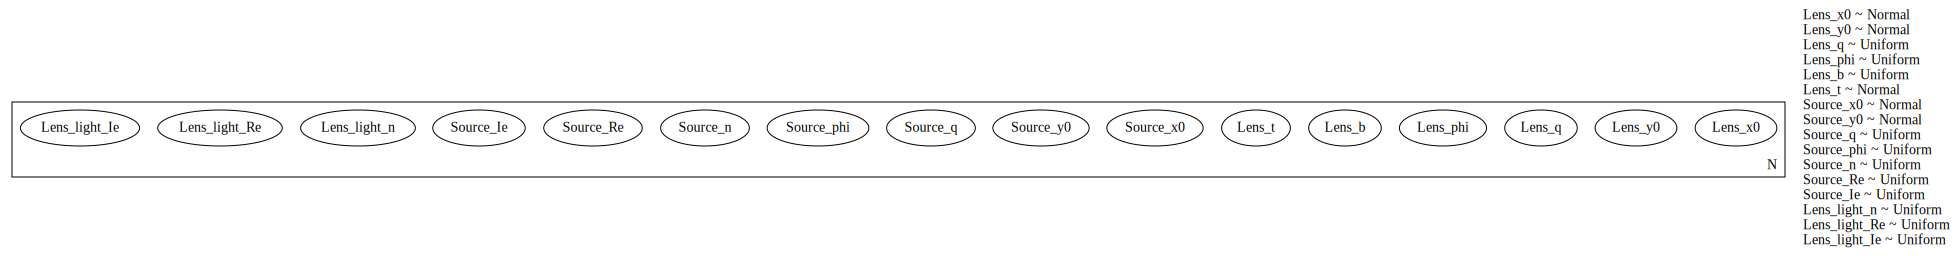

In [ ]:
import pyro
pyro.render_model(prior, model_args=(1, simulator, prior_params), render_distributions=True, render_params=False)

# Exploration

## Example 1: Sample the full parameter space

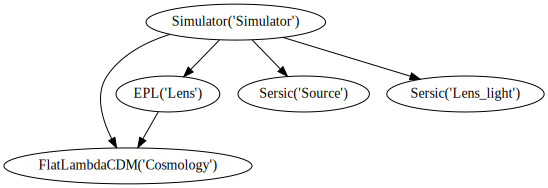

In [ ]:
simulator = Simulator()
simulator.get_graph()

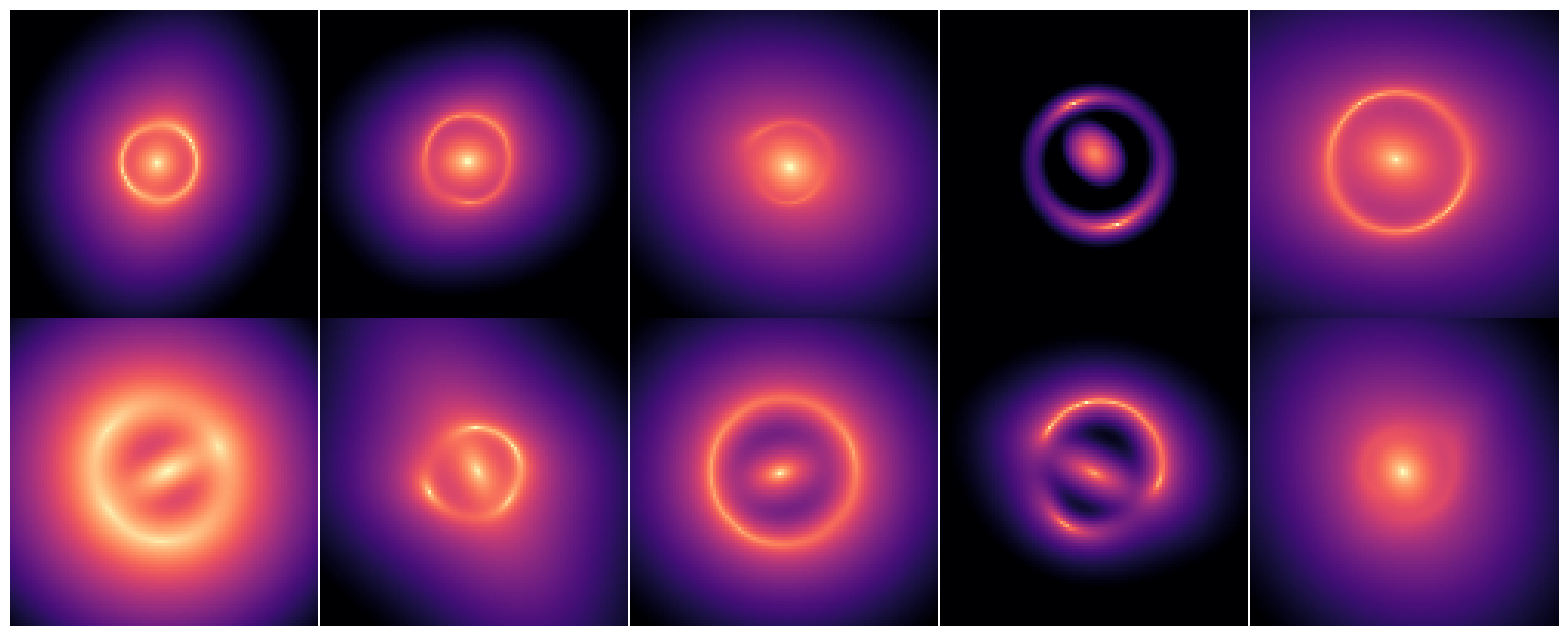

In [ ]:
with torch.no_grad():
    N = 10
    params = prior(N, simulator, prior_params)
    y = vmap(simulator)(params)

fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for i in range(2):
    for j in range(5):
        k = i * 5 + j
        axs[i, j].imshow(y[k], cmap="magma", norm=plt.cm.colors.LogNorm(vmin=1, clip=True))
        axs[i, j].axis("off")
plt.subplots_adjust(hspace=0, wspace=0)

## Example 2: Simulate without lens light

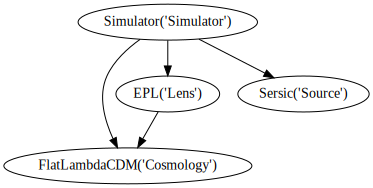

In [ ]:
simulator = Simulator(with_lens_light=False)
simulator.get_graph()

(array([9.4186e+04, 3.7280e+03, 1.0180e+03, 3.6900e+02, 1.4800e+02,
        1.0600e+02, 8.4000e+01, 4.2000e+01, 4.3000e+01, 4.1000e+01,
        2.9000e+01, 4.0000e+01, 2.4000e+01, 1.9000e+01, 8.0000e+00,
        7.0000e+00, 1.7000e+01, 9.0000e+00, 7.0000e+00, 8.0000e+00,
        5.0000e+00, 5.0000e+00, 7.0000e+00, 8.0000e+00, 0.0000e+00,
        2.0000e+00, 4.0000e+00, 2.0000e+00, 5.0000e+00, 3.0000e+00,
        1.0000e+00, 0.0000e+00, 3.0000e+00, 2.0000e+00, 1.0000e+00,
        1.0000e+00, 0.0000e+00, 4.0000e+00, 0.0000e+00, 3.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.00

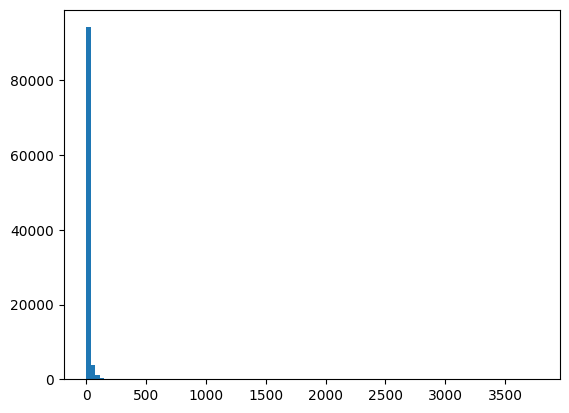

In [ ]:
# Our sampling function automatically picks up the fact we we do not have the lens light anymore
with torch.no_grad():
    N = 10
    params = prior(N, simulator, prior_params)
    y = vmap(simulator)(params)

plt.hist(y.cpu().flatten(),bins=100)

## Example 3: Fix some of the parameters (this is useful to simplfy the problem)

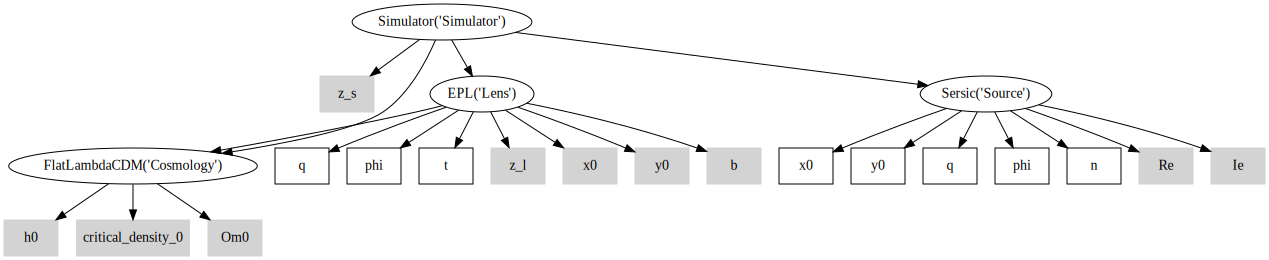

In [ ]:
simulator.lens.b = 0.5
simulator.lens.x0 = 0
simulator.lens.y0 = 0
simulator.source.Ie = 10
simulator.source.Re = 0.4
simulator.get_graph(True, True)

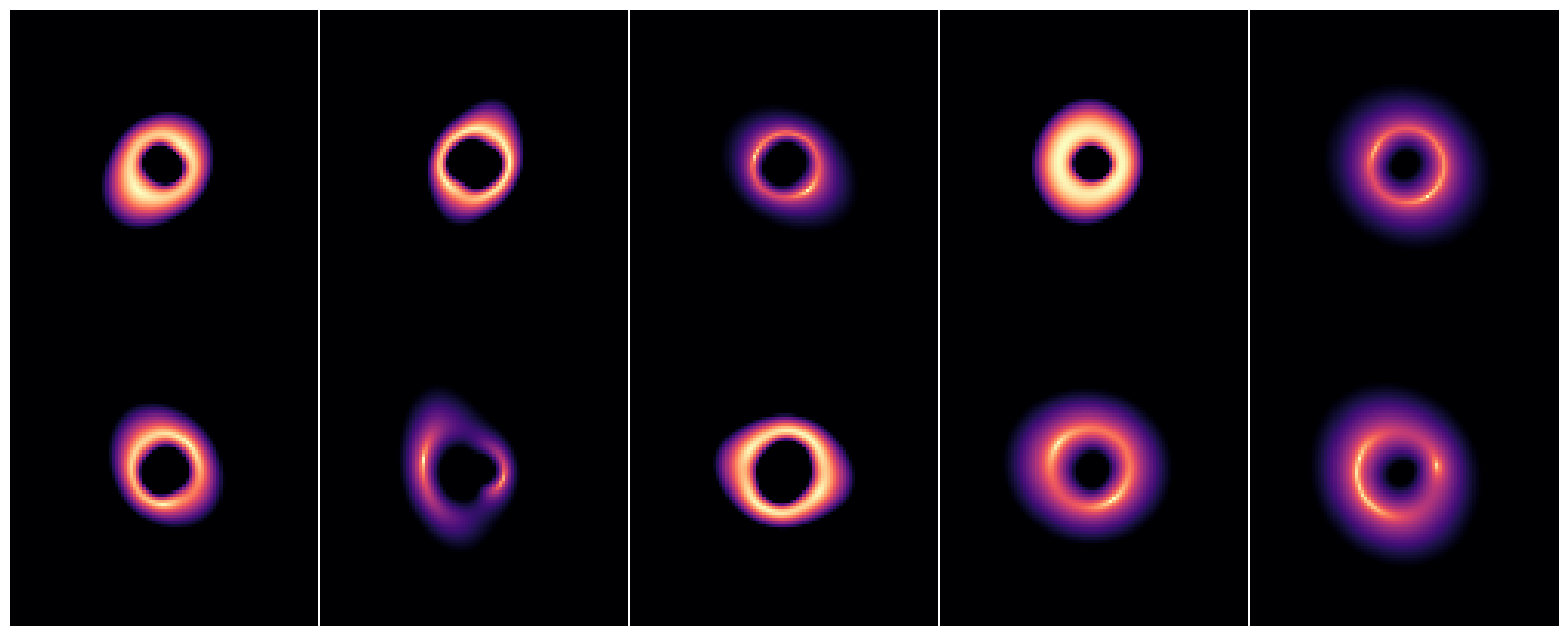

In [ ]:
# Our sampling function automatically picks up the fact we we do not have the lens light anymore
with torch.no_grad():
    N = 10
    params = prior(N, simulator, prior_params)
    y = vmap(simulator)(params)

fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for i in range(2):
    for j in range(5):
        k = i * 5 + j
        axs[i, j].imshow(y[k], cmap="magma", norm=plt.cm.colors.LogNorm(vmin=1, clip=True))
        axs[i, j].axis("off")
plt.subplots_adjust(hspace=0, wspace=0)

In [ ]:
# # You can make the parameter dynamic again by doing the following (or reinitialize the simulator)
# simulator.lens.b = None
# simulator.lens.x0 = None
# simulator.lens.y0 = None
# # simulator.get_graph(True, True)

# Dataset

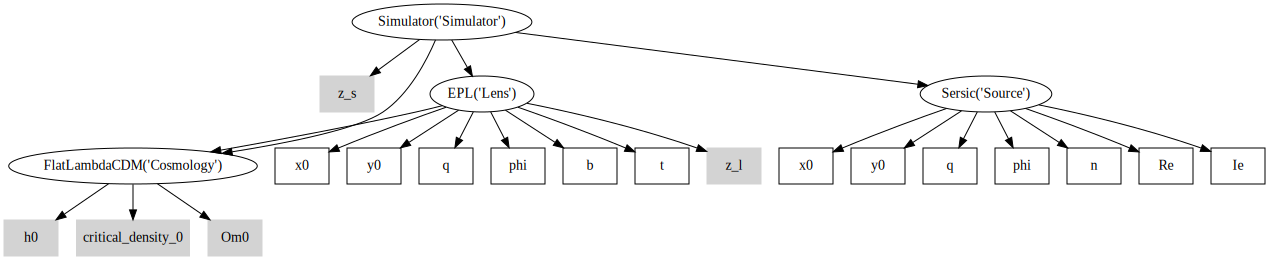

In [ ]:
simulator = Simulator(with_lens_light=False, n_pix=64)
simulator.get_graph(True, True)

In [ ]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, size, batch_size, simulator, prior_params, noise_std):
      self.simulator = simulator
      self.prior_params = prior_params
      self.prior = lambda: prior(self.batch_size, self.simulator, self.prior_params)
      self.size = size
      self.batch_size = batch_size
      self.noise_std = noise_std

  def __len__(self):
      return self.size

  def __getitem__(self, index):
      params = self.prior()
      y = vmap(self.simulator)(params)
      # Simulate noise
      y += torch.randn_like(y) * self.noise_std
      # Reshape params for inference
      y = torch.unsqueeze(y, dim = 1)
      params_tensor = params["Lens"]
      # for name, p in params.items():
      out = []
      for p_value in params_tensor.values():
          out.append(p_value)
      params_tensor = torch.stack(out, dim=1)
      # Note that you can use the simulator with the flattened tensor also
      # y = vmap(simulator)(params_tensor) will work, just as it does with the dictionary.
      return y, params_tensor # Input is the simulated image, labels are the parameters of interest


In [ ]:
class Hack(torch.utils.data.Dataset):
  def __init__(self, size, batch_size, simulator, prior_params, noise_std):
      self.simulator = simulator
      self.prior_params = prior_params
      self.prior = lambda: prior(self.batch_size, self.simulator, self.prior_params)
      self.size = size
      self.batch_size = batch_size
      self.noise_std = noise_std

  def __len__(self):
      return self.size

  def __getitem__(self, index):
      params = self.prior()
      y = vmap(self.simulator)(params)
      # Simulate noise
      y += torch.randn_like(y) * self.noise_std
      # Reshape params for inference
      y = torch.unsqueeze(y, dim = 1)
      params_tensor = params#["Lens"]
      out = []
      for name, p in params.items():
          for p_value in p.values():
              out.append(p_value)
      params_tensor = torch.stack(out, dim=1)
      # Note that you can use the simulator with the flattened tensor also
      # y = vmap(simulator)(params_tensor) will work, just as it does with the dictionary.
      return y, params_tensor # Input is the simulated image, labels are the parameters of interest


In [ ]:
dataset = Dataset(1000, 32, simulator, prior_params, 0.1)
dataset[0][1].shape

torch.Size([32, 6])

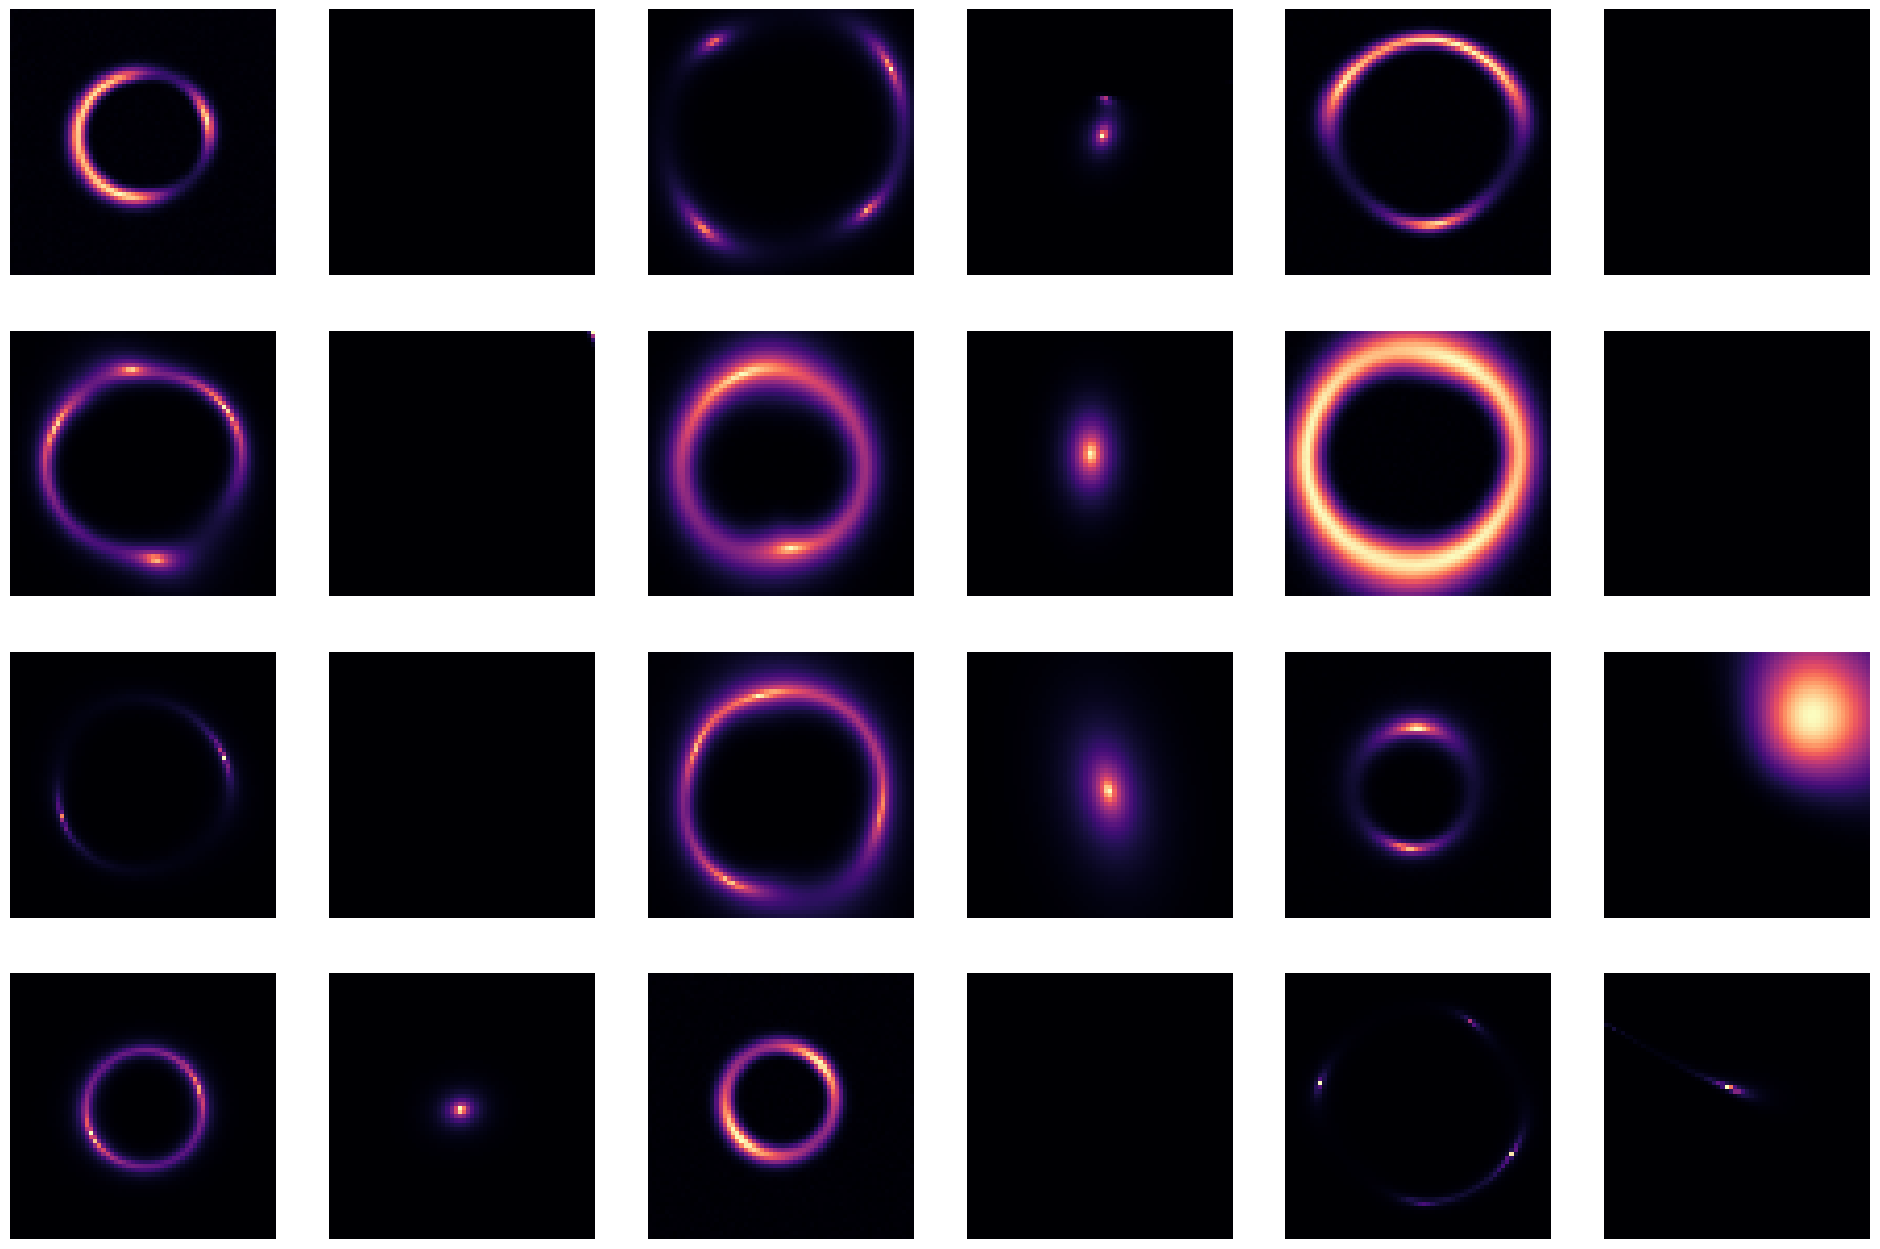

In [ ]:
with torch.no_grad():
  dataset = Hack(1000, 12, simulator, prior_params, 0.1)
  true_image, true_params = dataset[0]

  net_output = model(true_image)

  pred_params = torch.cat([net_output, true_params[:, 6:]], axis=1)

  y_pred = vmap(simulator)(pred_params)


  fig, axs = plt.subplots(4, 6, figsize=(6*4, 4*4))
  for i in range(4):
    for j in range(3):
      k = i * 3 + j
      axs[i, 2*j].imshow(true_image[k].squeeze().cpu(), cmap="magma")
      axs[i, 2*j].axis("off")

      axs[i, 2*j+1].imshow(y_pred[k].squeeze().cpu(), cmap="magma")
      axs[i, 2*j+1].axis("off")

In [ ]:
model

In [ ]:
# for epoch in range(epochs):
#     for y, x in dataset: # y is the input to the network, x are the labels.
#         print(y.shape, x.shape)
#         # Do your otimization here
#         break

# Vanilla CNN

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from torch.utils.tensorboard import SummaryWriter


In [ ]:
# Hyperparameters
learning_rate = 0.0001

num_epochs = 1

# Here is an example how to use the dataset, using a batch size of 64.
size = 1000 # this is arbitrary; sets the length of an epoch
batch_size = 32
noise_std = 1
dataset = Dataset(size, batch_size, simulator, prior_params, noise_std)

val_size = 1024
val_batch_size = 32
val_total_images = val_batch_size * val_size

val_dataset = Dataset(val_size, val_batch_size, simulator, prior_params, noise_std)

# # Data preprocessing
# transform = transforms.Compose([
#     transforms.Normalize((0.5), (0.5)),
#     transforms.ToTensor()
# ])

# class CustomDataset(Dataset):
#     def __init__(self, data, transform=None):
#         self.data = data
#         self.transform = transform

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         sample = self.data[idx]
#         if self.transform:
#             sample = self.transform(sample)
#         return sample

# custom_data = CustomDataset(dataset, transform=transform)
# val_custom_data = CustomDataset(val_dataset, transform=transform)


train_loader = DataLoader(dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)

def preprocessing(x):
    x_max = x.flatten().max()
    x_min = x.flatten().min()
    x = (((x-x_min)/(x_max-x_min))*2) - 1
    return x

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=7, padding="same") #padding same
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding="same")
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding="same")
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding="same")
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2) #avgpool
        self.dropout = nn.Dropout(0)
        self.fc1 = nn.Linear(32 * 4 * 4, 128)  # Adjust input size based on conv4 output size
        self.fc2 = nn.Linear(128, num_classes)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(32)
        self.bn4 = nn.BatchNorm2d(32)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)
        x = self.pool(x)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [ ]:
num_classes = 6#13 # 6
# Instantiate the model
model = SimpleCNN(num_classes)

# Loss function and optimizer
criterion = nn.MSELoss()  # Use Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience = 2, verbose = True)

In [ ]:
x = torch.randn(batch_size, 1, 64, 64)
print(model(x).shape)

model.load_state_dict(torch.load(f'/content/drive/MyDrive/Colab Notebooks/run5/checkpoint286.pt'))

torch.Size([32, 6])


<All keys matched successfully>

In [ ]:
import csv

In [ ]:
model.load_state_dict(torch.load(f'/content/drive/MyDrive/Colab Notebooks/run5/checkpoint286.pt'))

filename = "/content/drive/MyDrive/Colab Notebooks/run5/Loss.csv"

# saving loss and validation in a list
# trainLoss = []
# valLoss = []

# Training loop
image_num = 0
for epoch in range(num_epochs):
    print(f"Hi, you have started training on epoch {epoch}")
    model.train()
    running_loss = 0.0  # Track loss over 5 batches
    for batch_idx, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        images = images.view(-1, 1, 64, 64) # 64 64
        images = preprocessing(images)
        outputs = model(images)
        loss = criterion(outputs, labels.float())  # Convert labels to float for regression loss
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Print loss every 5 batches
        if batch_idx % 5 == 4:
            trainLoss.append(running_loss/5)
            if batch_idx % 50 == 49:
                image_num += (50)*batch_size
                print(f"Epoch [{epoch+1}/{num_epochs}] - Batch [{batch_idx+1}/{len(train_loader)}] - Loss: {running_loss/5:.4f} - Images: {image_num}")
            running_loss = 0.0
            # scheduler.step(running_loss/5)


    # Print loss at the end of each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {loss:.4f}")

    # Save model weights
    torch.save(model.state_dict(), f'/content/drive/MyDrive/Colab Notebooks/run5/checkpoint{epoch}.pt')

    # Write the lists to the CSV file
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Training'])  # Write header
        for item1 in zip(trainLoss):
            writer.writerow([item1])



# # Load model weights
# model.load_state_dict(torch.load(f'/content/drive/MyDrive/Colab Notebooks/runs/checkpoint{epoch}.pt'))

Hi, you have started training on epoch 0
Epoch [1/1] - Batch [50/1000] - Loss: 0.0912 - Images: 1600
Epoch [1/1] - Batch [100/1000] - Loss: 0.0682 - Images: 3200
Epoch [1/1] - Batch [150/1000] - Loss: 0.1103 - Images: 4800
Epoch [1/1] - Batch [200/1000] - Loss: 0.0878 - Images: 6400
Epoch [1/1] - Batch [250/1000] - Loss: 0.0959 - Images: 8000
Epoch [1/1] - Batch [300/1000] - Loss: 0.1071 - Images: 9600
Epoch [1/1] - Batch [350/1000] - Loss: 0.0837 - Images: 11200
Epoch [1/1] - Batch [400/1000] - Loss: 0.0858 - Images: 12800
Epoch [1/1] - Batch [450/1000] - Loss: 0.0878 - Images: 14400
Epoch [1/1] - Batch [500/1000] - Loss: 0.0923 - Images: 16000
Epoch [1/1] - Batch [550/1000] - Loss: 0.0920 - Images: 17600
Epoch [1/1] - Batch [600/1000] - Loss: 0.0897 - Images: 19200
Epoch [1/1] - Batch [650/1000] - Loss: 0.0854 - Images: 20800
Epoch [1/1] - Batch [700/1000] - Loss: 0.0826 - Images: 22400
Epoch [1/1] - Batch [750/1000] - Loss: 0.0726 - Images: 24000
Epoch [1/1] - Batch [800/1000] - Los

In [ ]:
def canvas_ticks(obj):
    '''This provides ticks in to a blanck canvas, for singular plots
    use plt as the argumenet, for suplots, in for gridspec for expample
    insert ax1 as argument'''
    plt.rcParams['font.size'] = 12
    obj.minorticks_on()
    obj.tick_params(labelsize=12)
    obj.tick_params(labelbottom=True, labeltop=False, labelright=False, labelleft=True)
    obj.tick_params(direction='in',which='minor', length=5, bottom=True, top=True, left=True, right=True)
    obj.tick_params(direction='in',which='major', length=10, bottom=True, top=True, left=True, right=True)

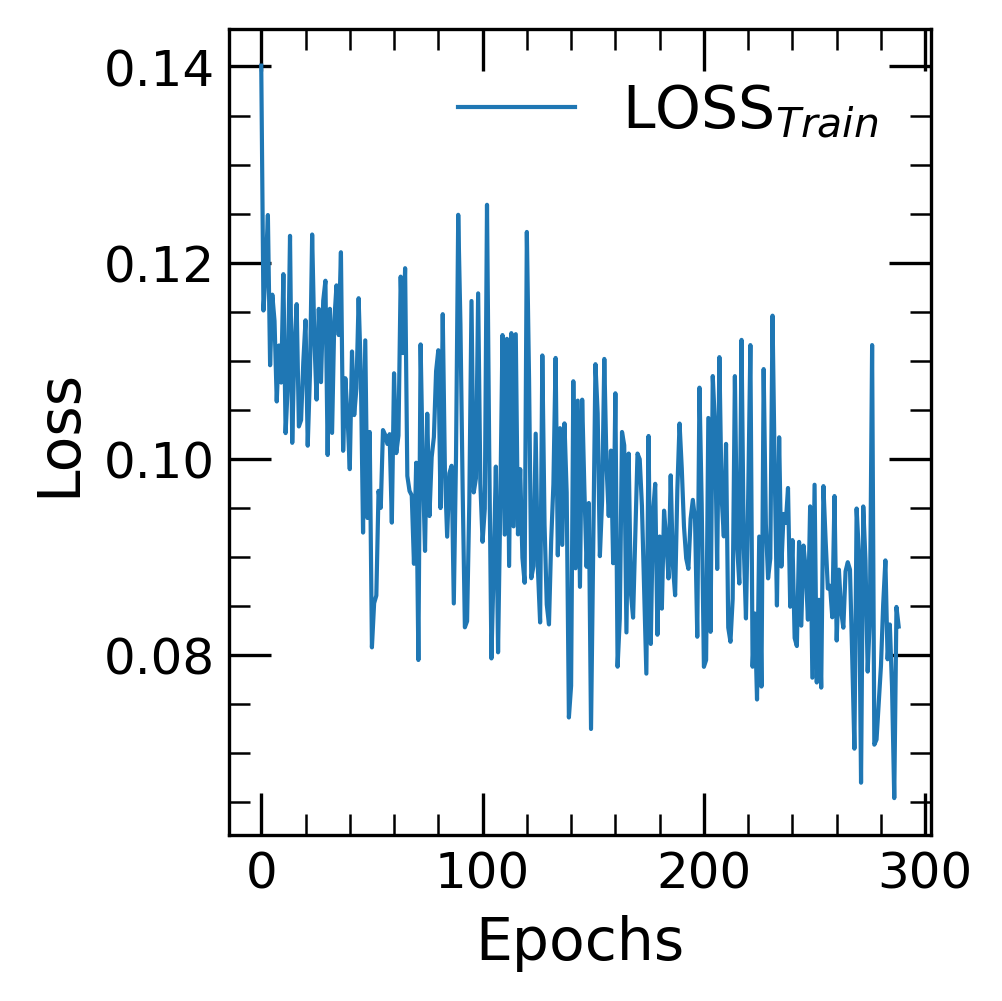

In [ ]:

plt.figure(figsize = (3.5,3.5), dpi = 300)

epochList = np.arange(1,6)

plt.plot(trainLoss[::200],  lw = 1, label = 'LOSS$_{Train}$')

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend(frameon = False)
canvas_ticks(plt)

plt.tight_layout()
plt.show()

In [ ]:
print(valLoss)

print(len(valLoss))
print(len(val_loader))

[]
0
1024


In [ ]:
# # remeber to normalize img
# # Validation example

# for batch_idx, (images, labels) in enumerate(val_loader):
#       optimizer.zero_grad()
#       images = images.view(-1, 1, 64, 64)
#       images = preprocessing(images)
#       model.eval()
#       with torch.no_grad():
#         # Assuming you have a validation image tensor named 'sample_image'
#         output = model(images)
#         predicted_value = output
#       outputs = model(images)
#       loss = criterion(outputs, labels.float())  # Convert labels to float for regression loss
#       loss.backward()

# sample_image=x
# model.eval()
# with torch.no_grad():
#     # Assuming you have a validation image tensor named 'sample_image'
#     output = model(sample_image)
#     predicted_value = output

# print(f"Predicted value: {predicted_value}")


In [ ]:
labelsList = []
predictedLabelsList = []

with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(val_loader):
        images = images.view(-1, 1, 64, 64)
        images = preprocessing(images)
        model.eval()

        # Assuming you have a validation image tensor named 'images'
        output = model(images).numpy()
        for i in labels.squeeze().numpy():
            # predictedLabelsList.append(output)  # Append individual value from output tensor
            labelsList.append(i)  # Append individual value from label tensor
        for j in output:
            predictedLabelsList.append(j)  # Append individual value from output tensor

print(predictedLabelsList[0])

print(len(labelsList))


[ 0.11582328 -0.08782351  0.5860397   2.073436    0.685882    2.018663  ]
32768


In [ ]:
np.array(predictedLabelsList).T[0].shape
np.array(predictedLabelsList).T[0]

# labels1 = []
# for line in labelsList:
#         labels1.append(line.split(6))

# Plabels1 = []
# for line in predictedLabelsList:
#         Plabels1.append(line.split(6))


# plt.plot(labels1,Plabels1)

array([ 0.11582328,  0.13780051,  0.03792001, ..., -0.01030921,
        0.05911359,  0.08034908], dtype=float32)

In [ ]:
predictedLabelsList

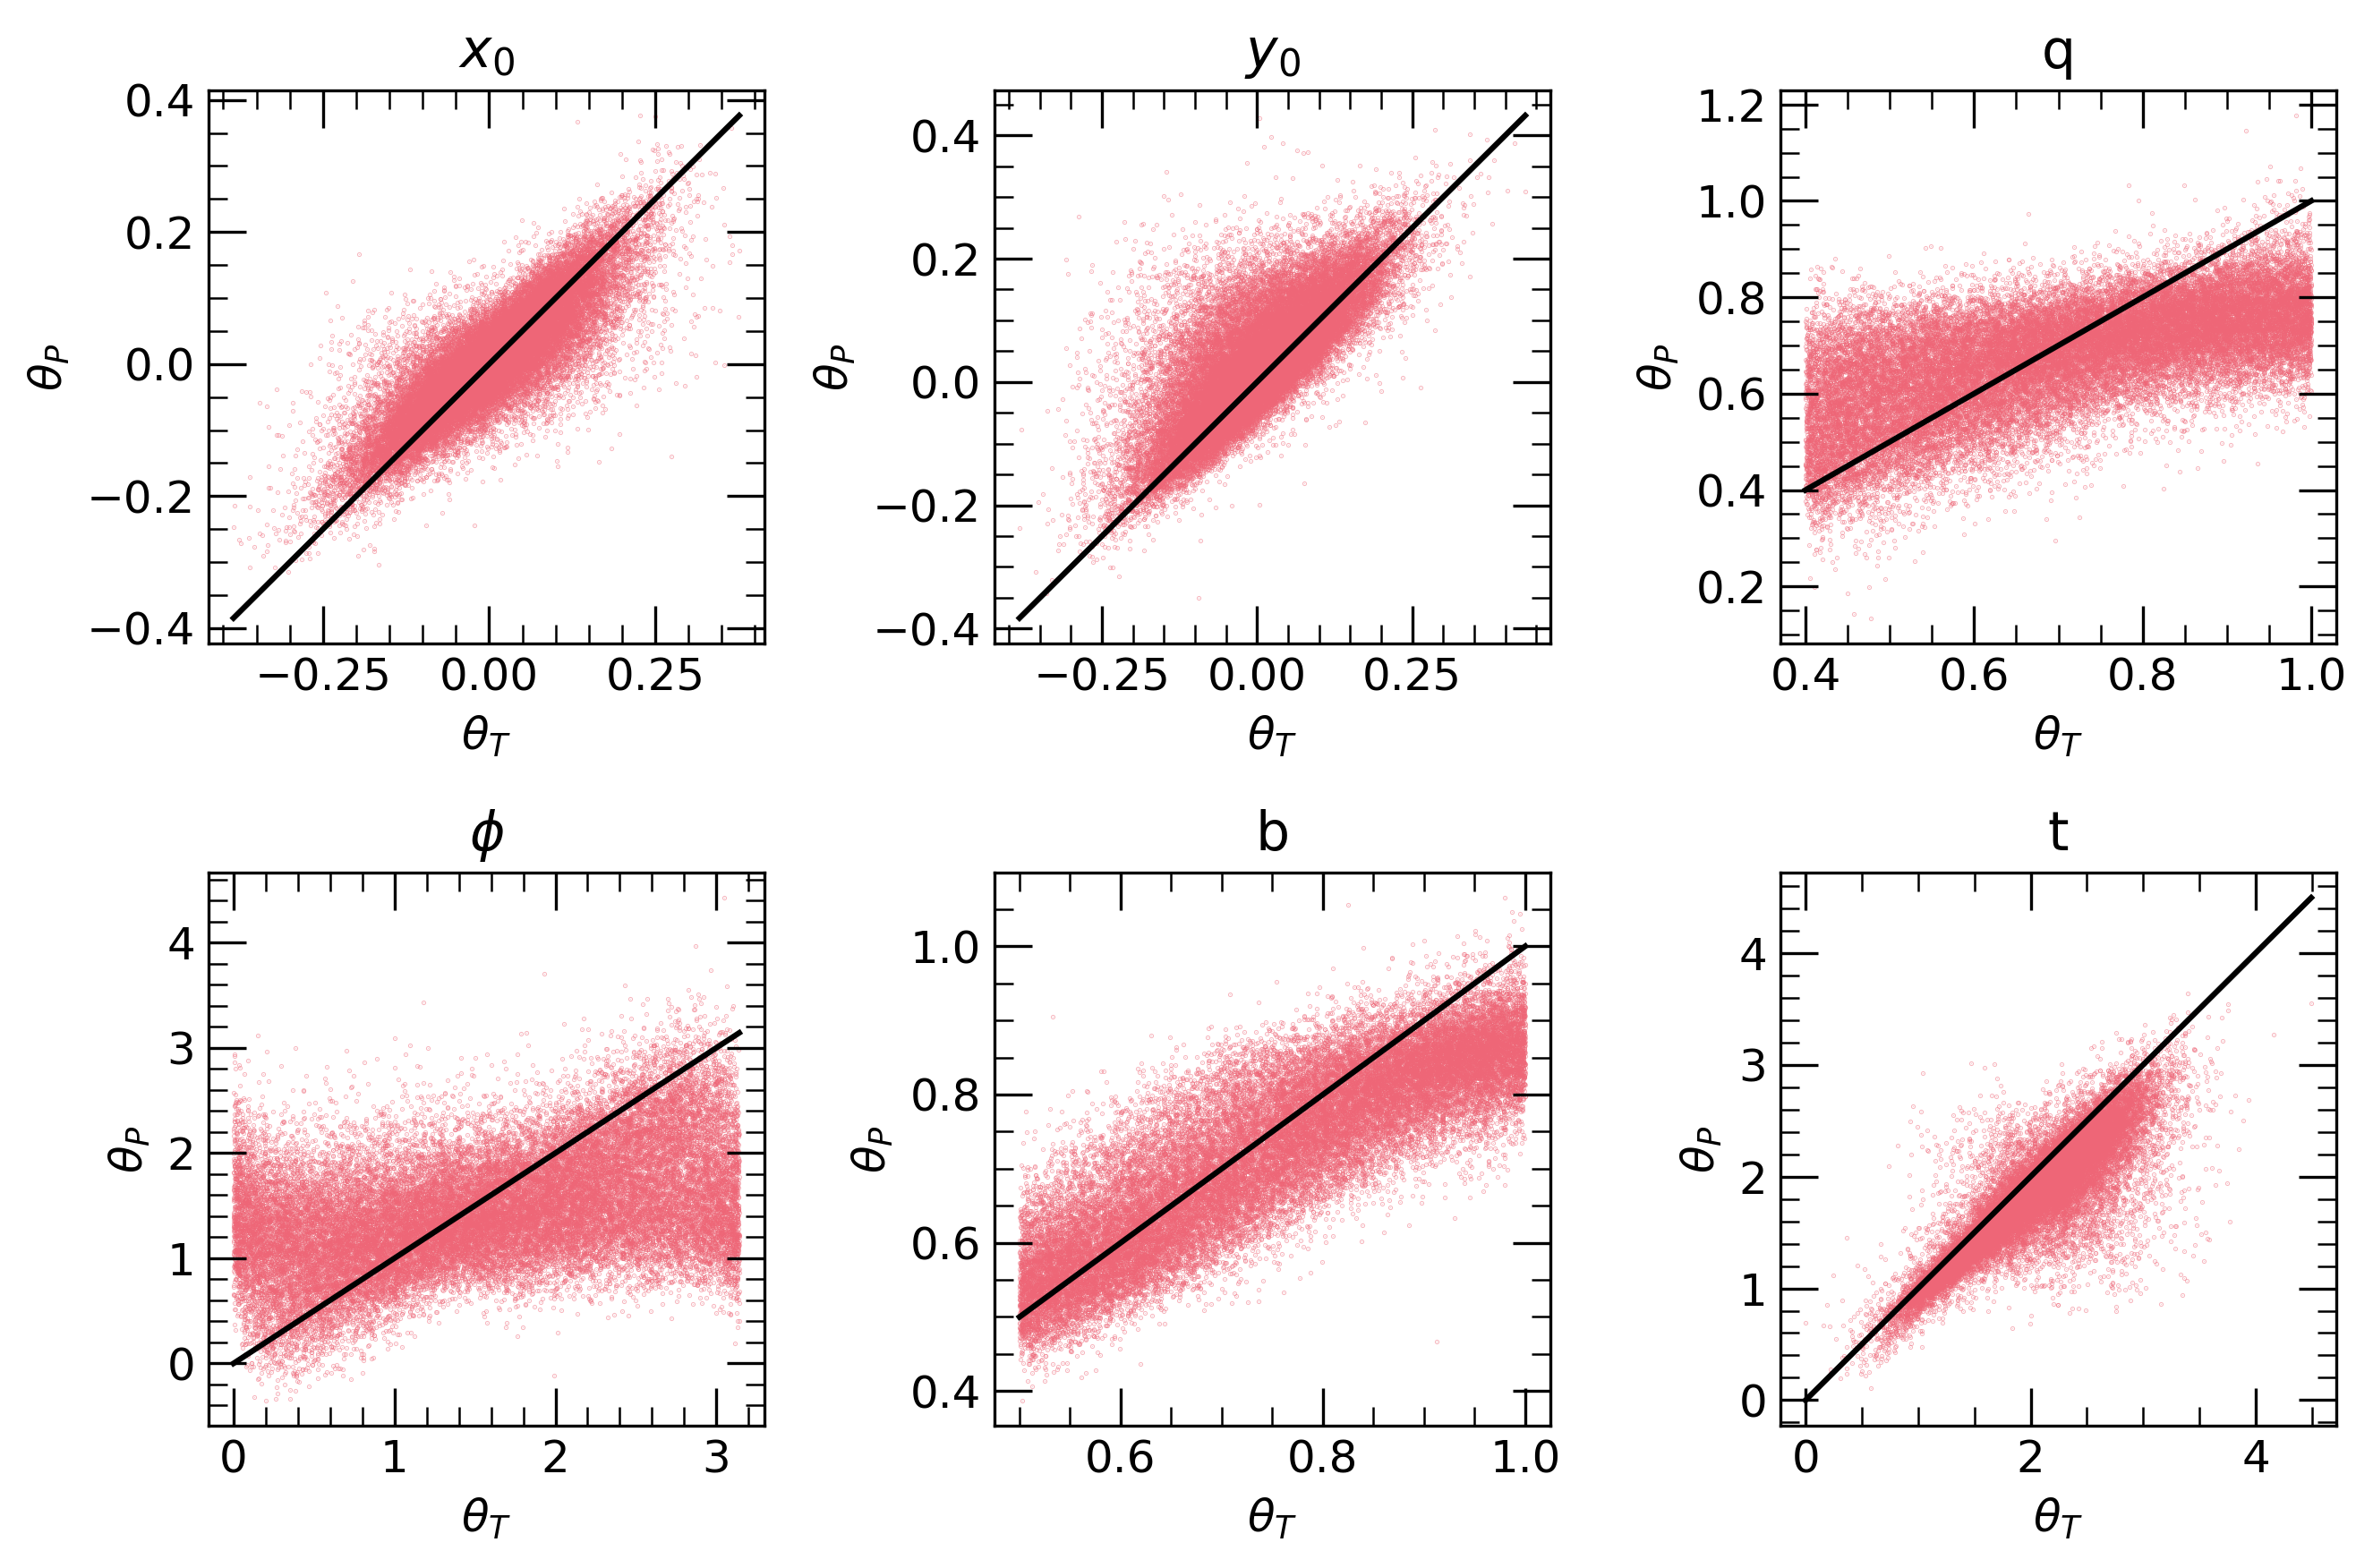

In [ ]:
fig, axs = plt.subplots(2,3,figsize = (9,6), dpi = 300)
params = ['$x_0$','$y_0$', 'q', '$\phi$', 'b','t']

for i, ax in enumerate(axs.flat):
  pred = np.array(predictedLabelsList).T[i]
  true = np.array(labelsList).T[i]

  x_true_min = min(true)
  x_true_max = max(true)

  ax.scatter(true,pred, s = 0.05 , color = '#EE6677', alpha = .5)
  ax.plot([x_true_min, x_true_max], [x_true_min, x_true_max], c = 'k')
  ax.set_xlabel('$\\theta_T$')
  ax.set_ylabel('$\\theta_P$')
  ax.set_title(params[i])
  canvas_ticks(ax)

plt.tight_layout()
plt.savefig('Jumbo.jpg', dpi = 300)
plt.show()

In [ ]:
$$



# $y = A\cdot\vec{\theta} + \sigma$

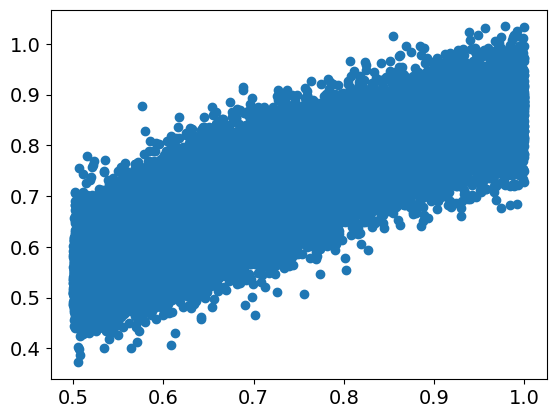

In [ ]:
i = 4
p = np.array(predictedLabelsList).T[i]
t = np.array(labelsList).T[i]
plt.scatter(t,p)

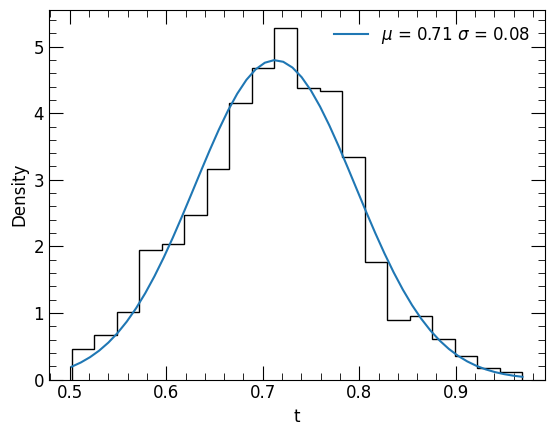

In [ ]:
idx = np.where((p > .69) & (p < .71))
bagel = t[idx]
from scipy.stats import norm

plt.hist(bagel, bins = 20, histtype = 'step', color = 'k', density = True)
mu, std = norm.fit(bagel)
x = np.linspace(min(bagel), max(bagel))
pdf = norm.pdf(x, mu, std)

#plot fit
plt.plot(x, pdf, label = f"$\mu$ = {mu:.2f} $\sigma$ = {std:.2f}")
plt.xlabel(params[i])
plt.ylabel('Density')
plt.legend(frameon = False)
canvas_ticks(plt)
plt.show()

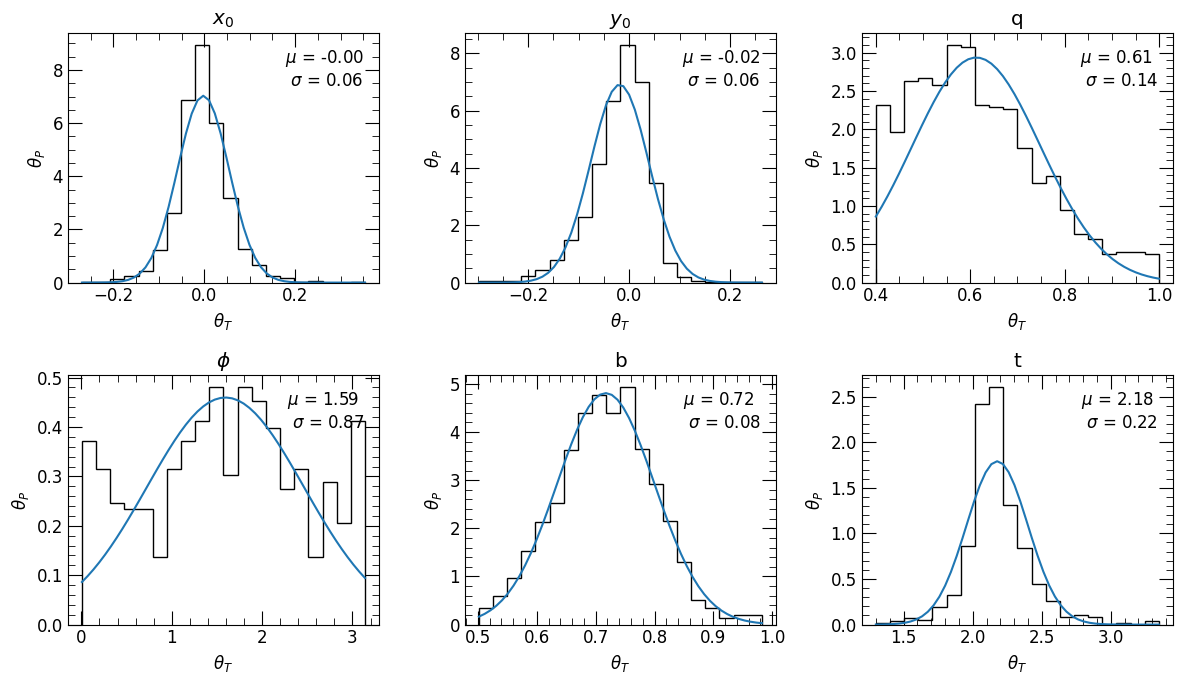

In [ ]:
fig, axs = plt.subplots(2,3,figsize = (12,7), dpi =100)
params = ['$x_0$','$y_0$', 'q', '$\phi$', 'b','t']
slic = [[-.01,0.01],[-.01,0.01],[0.59, 0.61],[1.49,1.51],[0.69,.71], [1.99,2.01]]
for i, ax in enumerate(axs.flat):
  pred = np.array(predictedLabelsList).T[i]
  true = np.array(labelsList).T[i]

  idx = np.where((pred > slic[i][0]) & (pred < slic[i][1]))
  bagel = true[idx]

  ax.hist(bagel, bins = 20, histtype = 'step', color = 'k', density = True)
  mu, std = norm.fit(bagel)
  x = np.linspace(min(bagel), max(bagel))
  pdf = norm.pdf(x, mu, std)
  ax.plot([], [], ' ', label = f"$\mu$ = {mu:.2f}\n $\sigma$ = {std:.2f}")

  #plot fi
  ax.plot(x, pdf, c = 'C0')
  ax.set_xlabel(params[i])
  ax.set_ylabel('Density')
  ax.legend(frameon = False, loc = 'upper right')
  canvas_ticks(ax)
  ax.set_xlabel('$\\theta_T$')
  ax.set_ylabel('$\\theta_P$')
  ax.set_title(params[i])

plt.tight_layout()
plt.savefig('JumboMSLICE.jpg', dpi = 300)
plt.show()

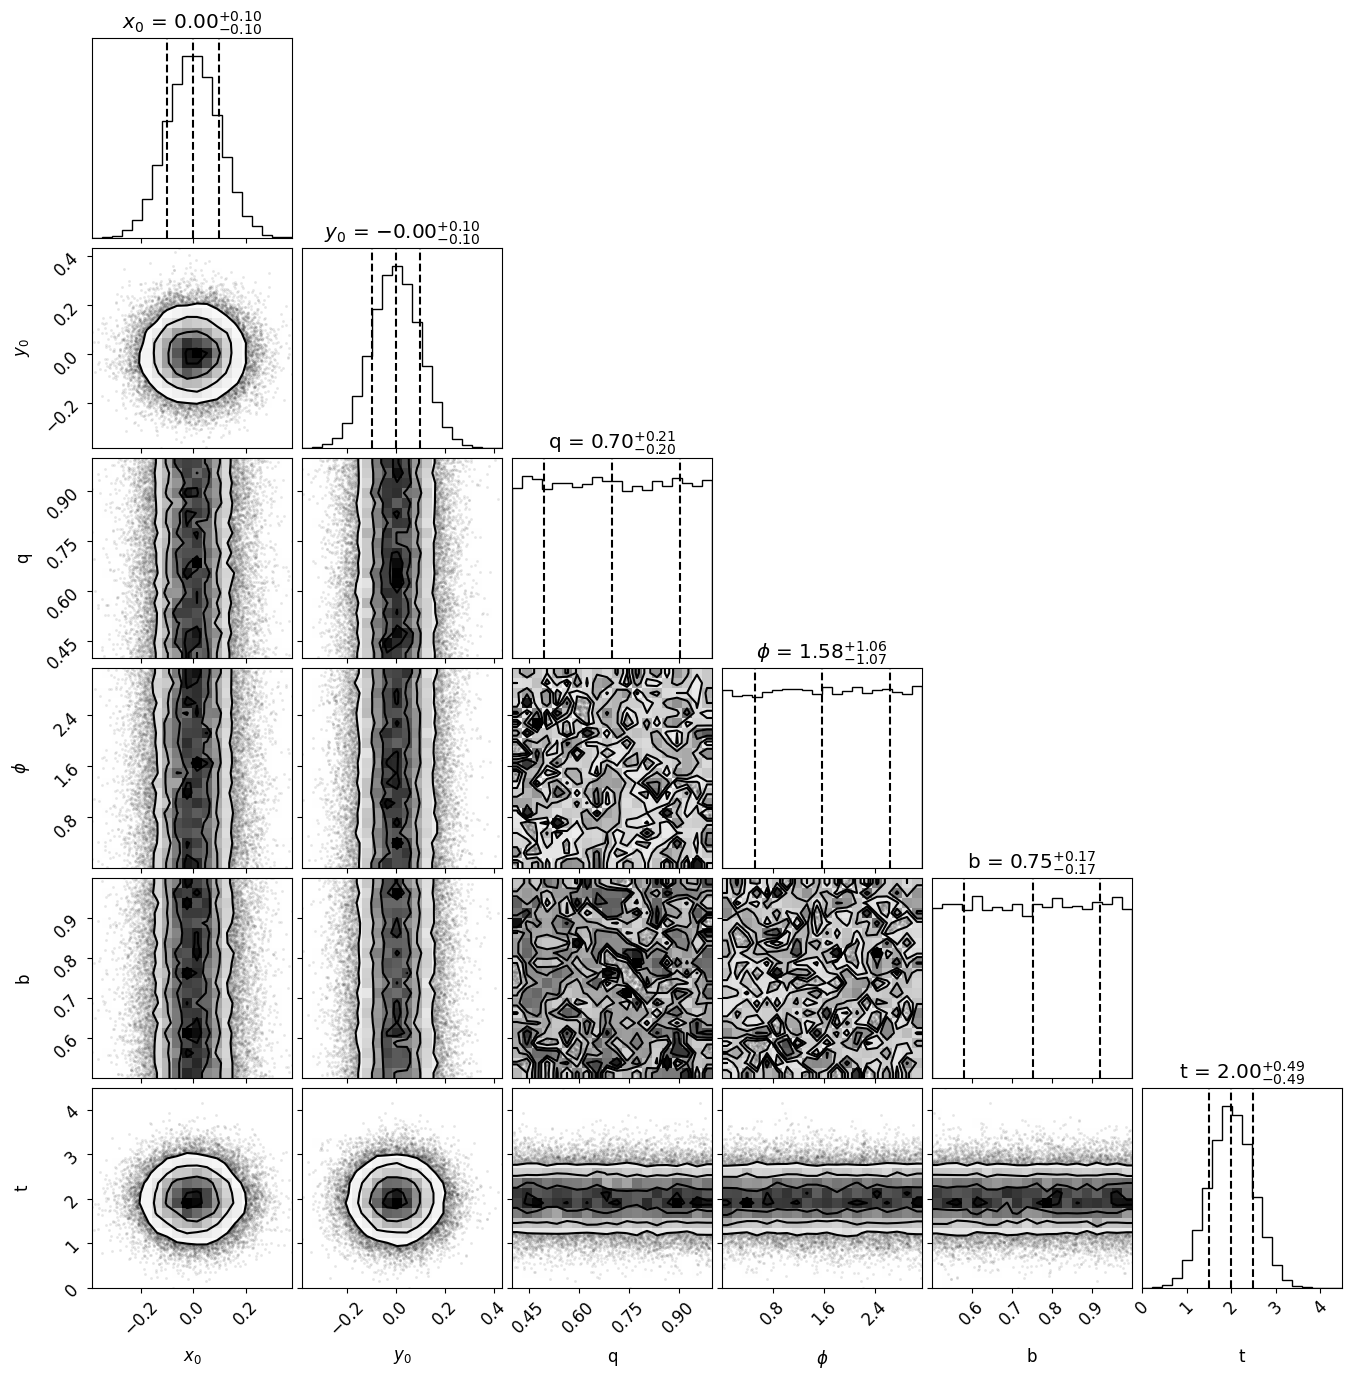

In [ ]:
x = np.array(labelsList)
y = np.array(predictedLabelsList)


# Flatten both x and y arrays
x_flat = x.flatten()
y_flat = y.flatten()

# Combine the flattened arrays
merged_data = np.vstack((x_flat, y_flat)).T


# Create the corner plot
corner_plot = corner.corner(
    x,
    quantiles=[0.16, 0.5, 0.84],  # Set quantiles for crosshairs
    labels=params,
    show_titles=True,
)

plt.savefig('moneyplotT.jpg',dpi = 300)
plt.show()


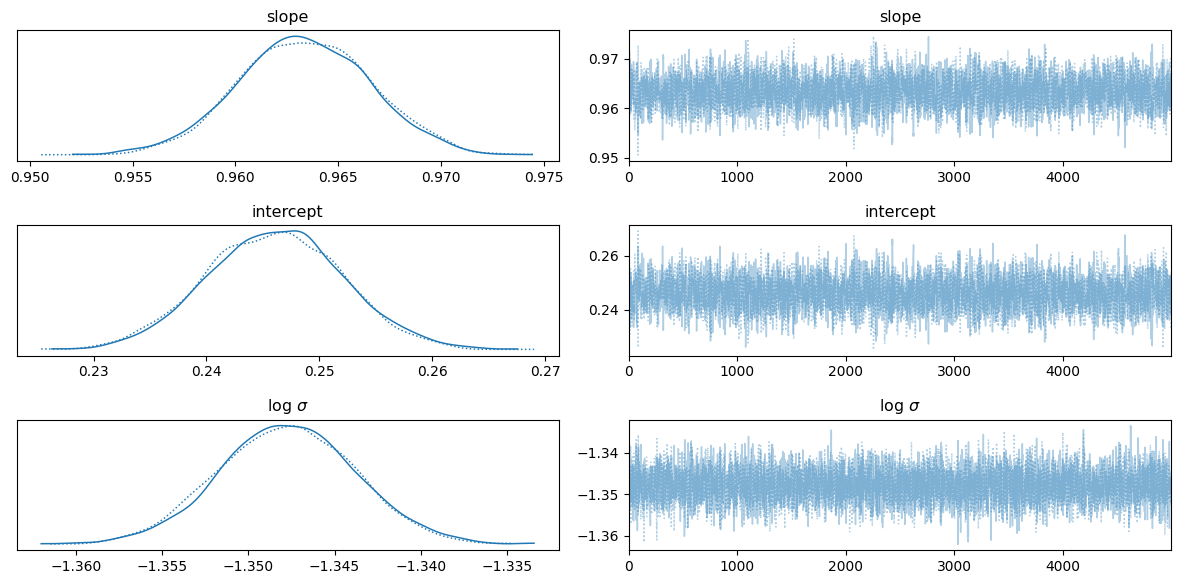

In [ ]:
x , y_true = pred, true
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import corner


# Define the PyMC3 model with intrinsic scatter
with pm.Model() as linear_model:
    # Priors for the parameters
    slope = pm.Normal("slope", mu=1, sigma=.5)
    intercept = pm.Normal("intercept", mu=0, sigma=.5)
    log_sigma = pm.Normal("log $\sigma$", mu = 0,  sigma=0.5)  # Intrinsic scatter parameter

    # Expected value of the observations
    expected = slope * x + intercept

    # Likelihood with intrinsic scatter
    likelihood = pm.Normal("likelihood", mu=expected, sigma=pm.math.exp(log_sigma), observed=y_true)

    # Perform MCMC sampling
    trace = pm.sample(5000, tune=1000, cores=1)  # You can adjust the number of samples and tuning steps
    _ = pm.plot_trace(trace)
    plt.tight_layout()

pm.summary(trace)
plt.savefig('logSigma.jpg', dpi = 300)

<Figure size 640x480 with 0 Axes>

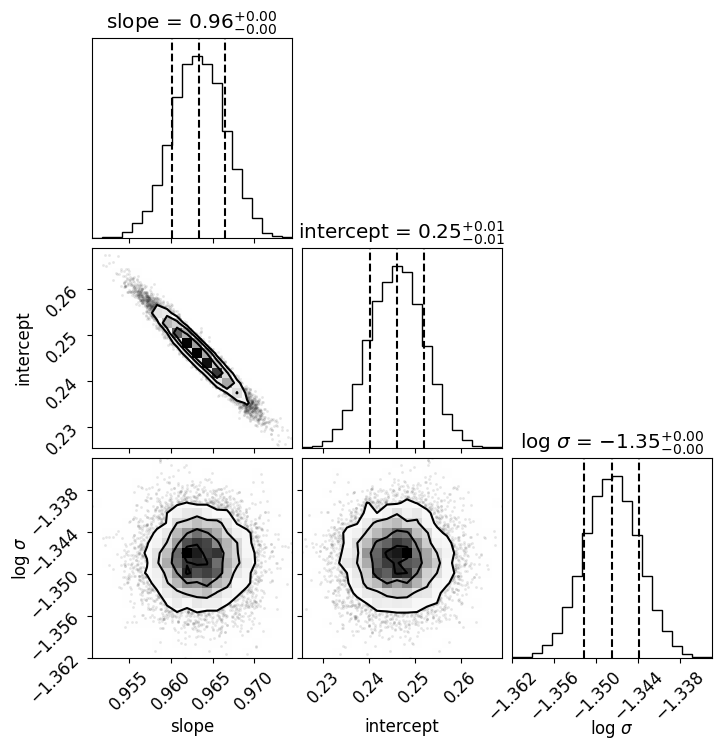

In [ ]:
plt.set_cmap('magma')
# Plot the corner plot
corner_plot = corner.corner(trace,quantiles = [0.16,0.5,0.84], varnames=["slope", "intercept", "scatter"],# Set colormap
    show_titles=True,)
plt.savefig('MCMC.jpg', dpi = 300)
plt.show()


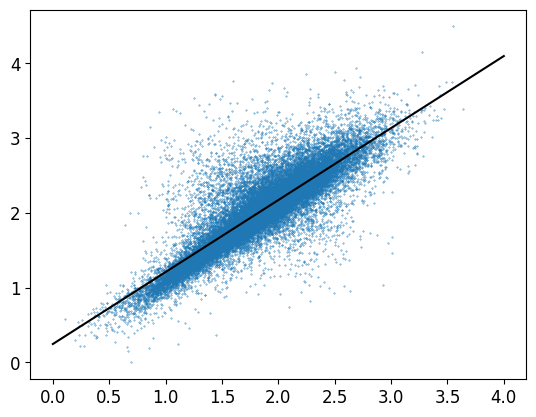

In [ ]:
plt.scatter(x, y_true, s = 0.1)
theta = np.linspace(0,4,100)
plt.plot(theta, .963*theta + .246, color = 'black')

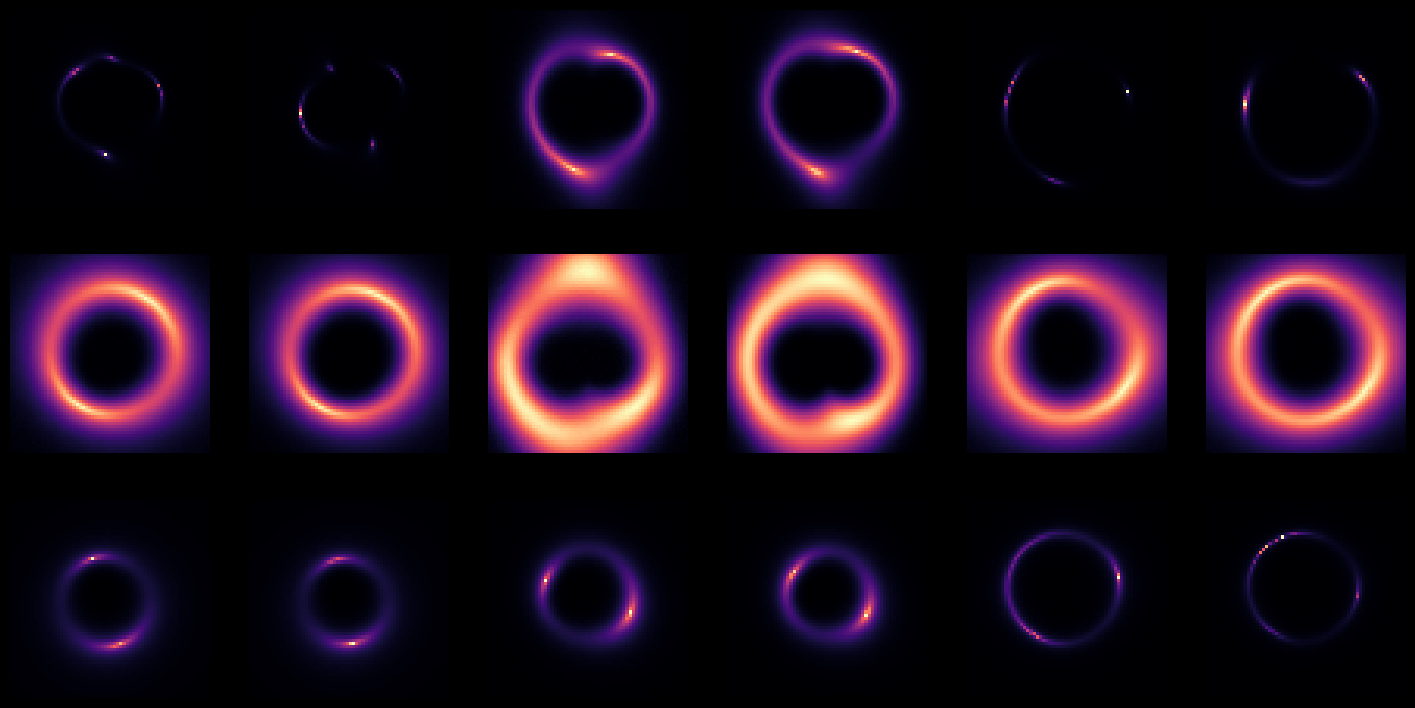

In [ ]:
with torch.no_grad():
  dataset = Hack(1000, 9, simulator, prior_params, 0.1)
  true_image, true_params = dataset[0]

  true_image = true_image.view(-1, 1, 64, 64)
  true_image = preprocessing(true_image)

  net_output = model(true_image)

  pred_params = torch.cat([net_output, true_params[:, 6:]], axis=1)

  y_pred = vmap(simulator)(pred_params)


  fig, axs = plt.subplots(3, 6, figsize=(6*3, 3*3), facecolor = 'black')
  for i in range(3):
    for j in range(3):
      k = i * 3 + j
      axs[i, 2*j].imshow(true_image[k].squeeze().cpu(), cmap="magma")
      axs[i, 2*j].axis("off")

      axs[i, 2*j+1].imshow(y_pred[k].squeeze().cpu(), cmap="magma")
      axs[i, 2*j+1].axis("off")

plt.savefig('Magma5.jpg', dpi = 300)

In [ ]:
# import pymc as pm

# with pm.Model() as linear_model:
#     # Prior distributions for slope and intercept
#     slope = pm.Normal('slope', mu=0, sd=10)
#     intercept = pm.Normal('intercept', mu=0, sd=10)

#     # Model prediction
#     y_pred = slope * X + intercept

#     # Likelihood (modeling the observed data)
#     likelihood = pm.Normal('y', mu=y_pred, sd=2.0, observed=y)

In [ ]:
import pyro
import pyro.distributions as dist
from pyro.distributions import MixtureOfDiagNormals

In [ ]:
## this is our MDN babyyyy

# Define the Mixture Density Network (MDN) class
class MDN(nn.Module):
    def __init__(self, input_size, num_mixtures, hidden_size):
        super(MDN, self).__init__()

        self.num_mixtures = num_mixtures

        self.mdn_layers = nn.Sequential(
        nn.Linear(6, 128),  # Adjust input size based on conv4 output size
        nn.ReLU()

        )

        # Modify the output layer for MDN
        self.output_layer = nn.Linear(128, num_mixtures * 3 * 6)  # Parameters for mean, variance, weight


    def forward(self, x):
            cnn_output = self.mdn_layers(x)
            mixture_params = self.output_layer(cnn_output)
            print(mixture_params.shape)
            # Separate mixture parameters for mean, log-variance, and weight
            # print(torch.split(mixture_params[0], 6 * 3 , dim=0))
            mean_params, log_variance_params, log_weight_params = torch.split(mixture_params, num_mixtures * 6 , dim=1)

            # Apply appropriate activation functions or transformations
            # For example, using torch.exp to ensure positive variances
            variance_params = torch.exp(log_variance_params)



            weight_params = torch.softmax(log_weight_params, dim=1)

            return mean_params, variance_params, weight_params


def mdn_loss(y_true, mean_params, variance_params, weight_params):
    # Separate mixture parameters for mean, log-variance, and weight
    # mean_params, log_variance_params, log_weight_params = torch.split(mixture_params, mixture_params.shape[1] // 3, dim=1)

    # Calculate the probability density function for each mixture component
    exponent = -0.5 * ((y_true - mean_params) ** 2) / variance_params
    log_prob = exponent - 0.5 * torch.log(variance_params) - 0.5 * torch.log(2 * np.pi)
    weighted_log_prob = log_prob + weight_params

    # Calculate the negative log-likelihood
    nll = -torch.logsumexp(weighted_log_prob, dim=1)

    return torch.mean(nll)

def mdn_loss(y_true, mean_params, variance_params, weight_params):
    num_mixtures = variance_params.shape[2]  # Get the number of mixtures

    # Calculate the probability density function for each mixture component
    exponent = -0.5 * ((y_true.unsqueeze(2) - mean_params) ** 2) / variance_params
    log_prob = exponent - 0.5 * torch.log(variance_params) - 0.5 * torch.log(2 * np.pi)
    weighted_log_prob = log_prob + weight_params

    # Calculate the negative log-likelihood
    nll = -torch.logsumexp(weighted_log_prob, dim=2).sum(dim=1)

    return torch.mean(nll)


def mdn_likelihood(mean_params, variance_params, weight_params, target):
    component_dist = dist.Normal(mean_params, torch.sqrt(variance_params))
    mixture_dist = dist.Categorical(logits=mixing_coeffs)
    likelihood = dist.MixtureOfDiagNormals(mixture_dist, component_dist)

    return likelihood.log_prob(target).sum(dim=-1)



In [ ]:
input_size = 4096
num_mixtures = 5
hidden_size = 128

mdn_model = MDN(input_size, num_mixtures, hidden_size)

thetaPred = model(images)
mean, sigma, weights = mdn_model(thetaPred)
# print(mdn_model(thetaPred))
loss = mdn_loss(labels.squeeze(), mean, sigma, weights)



torch.Size([32, 90])


IndexError: ignored